In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Data Analysis Question-1 

Are player positions structured the same across all teams? What I would like to know is whether all teams have a similar distribution of players in different roles, such as batsmen, bowlers, wicketkeepers, and so on.
#### Answer - 1

In [2]:
# Load the dataset
player_data = pd.read_csv("database/player_data.csv")

In [3]:
# First, let's examine a frequency table of player roles within teams.
frequency_table = player_data.pivot_table(values='Name', index=['Team'], columns=['Role'], aggfunc=len, fill_value=0, 
                                          margins=True)
frequency_table

Role,Allrounder,Batter,Batting Allrounder,Bowler,Bowling Allrounder,Middle order Batter,Opening Batter,Top order Batter,Wicketkeeper Batter,All
Team,,,,,,,,,,
CSK,5,2,1,10,4,1,0,2,2,27
DC,3,0,0,11,1,3,2,4,3,27
GT,3,0,1,11,3,1,1,2,4,26
KKR,6,0,0,9,1,2,3,1,3,25
LSG,5,1,2,12,2,0,1,0,3,26
MI,1,1,3,14,1,2,0,2,3,27
PBKS,4,2,3,8,0,1,1,2,3,24
RCB,5,1,4,11,2,1,0,3,2,29
RR,3,0,0,12,2,0,1,4,4,26


From the frequency table, it is evident that teams do not follow the same distribution of players across player roles.
Now, let's take a look at a stacked bar chart to gain a better understanding.

In [4]:
playing_positions = player_data.groupby(["Team", "Role"]).size().unstack()
# Choose color palette for chart
num_categories = len(playing_positions.columns)
colors = sns.color_palette('Set3', num_categories)

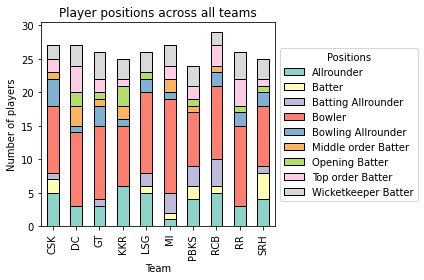

In [5]:
# Plot the graph
ax = playing_positions.plot(kind="bar", stacked=True, color=colors, edgecolor="black")
ax.set_xlabel("Team")
ax.set_ylabel("Number of players")
ax.set_title("Player positions across all teams")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Positions")
plt.tight_layout()
plt.show()

#### Conclusion for Question-1
It appears that there is no common structure for player positions among teams. Each team seems to have a unique arrangement based on their individual circumstances. One possible reason for this variation could be the presence of star players in different positions. For example, if a team has two exceptional bowlers, they may be less inclined to include additional backup bowlers in their team. In addition to the influence of star players, it's worth noting that coaches sometimes exhibit a preference for certain player positions as well. They may have a strategic or tactical inclination towards emphasizing specific roles within the team composition. This further contributes to the diversity and variation in player positions across different teams.


## Data Analysis Question - 2

Powerplay. A important part of modern fast paced cricket. So, what is powerplay exactly? Well, based on wikipedia entry: In a powerplay, restrictions are applied on the fielding team, with only two fielders allowed outside the 30-yard circle for a set number of overs. In 20 overs match, first six overs are powerplay overs. It is good opportunity for batters to set tone for the inning. My question is does teams who utilises powerplay more efficiently wins the match? I would like to know correlation between a team's performance in the power play and their overall match outcomes.

#### Answer - 2

In [6]:
# Load the dataset from relational database
conn = sqlite3.connect('database/ipl.db')
matches_data = pd.read_sql_query("SELECT * FROM matches", conn)
conn.close()

In [7]:
# Create a list of teams which were ahead compared to their opponent in each match
leading_teams = []
for index, row in matches_data.iterrows():
    inning1_pp_score = int(row["Powerplay score(i1)"].split("/")[0])
    inning2_pp_score = int(row["Powerplay score(i2)"].split("/")[0])
    run_difference = inning1_pp_score - inning2_pp_score
    home_team, away_team = row["Home Team"], row["Away Team"]
    toss_winner, toss_decision = row["Toss Win"], row["Field First"]
    if toss_decision == 1:
        inning2_team = toss_winner
        if toss_winner == home_team:
            inning1_team = away_team
        else:
            inning1_team = home_team
    else:
        inning1_team = toss_winner
        if toss_winner == home_team:
            inning2_team = away_team
        else:
            inning2_team = home_team
    # In case of two teams were at same runs at end of powerplay, I will give preference to team that batted first
    if run_difference >= 0:
        leading_teams.append(inning1_team)
    else:
        leading_teams.append(inning2_team)

In [8]:
# Now let's get the winning team data series
winning_team = matches_data["Winner"].tolist()

# Now let's compare them to find out how many teams were able to convert powerplay advantage
team_with_powerplay_lead_won = 0
for index in range(len(winning_team)):
    if winning_team[index] == leading_teams[index]:
        team_with_powerplay_lead_won += 1
    else:
        continue
        
conversion_percentage = (team_with_powerplay_lead_won / len(winning_team)) * 100
print(f"The percentage of teams that converted their power play runs lead into victory is: {conversion_percentage:.2f}%")

The percentage of teams that converted their power play runs lead into victory is: 67.12%


#### Conclusion for Question-2
With a percentage as high as <b>68.49%</b>, it indicates that teams that were in the lead during the powerplay phase tended to win the match more often than not. This suggests that having a strong performance during the powerplay can provide a significant advantage in achieving a positive outcome in the match.However, it is important to note that correlation does not necessarily imply causation. While a high conversion percentage indicates a strong association between powerplay lead and match victory, it does not guarantee that having the powerplay lead always guarantees a win.

## Data Analysis Question - 3

<b>Toss</b>. Considered an important aspect of cricket, is often believed to have the potential to influence match outcomes. In light of this, an intriguing question arises: How frequently have teams managed to translate their toss victory into a subsequent match win? Moreover, this prompts us to delve deeper and scrutinize the true significance of the toss result. Is it truly a decisive factor in determining the overall outcome of cricket matches?

#### Answer-3

In [9]:
# We have already loaded match dataset
toss_and_match_win = matches_data[matches_data["Winner"] == matches_data["Toss Win"]].shape[0]
total_matches = matches_data.shape[0]
percentage_win = toss_and_match_win/total_matches * 100
print(f"The percentage of teams that converted their toss win into victory is: {percentage_win:.2f}%")

The percentage of teams that converted their toss win into victory is: 45.21%


#### Conclusion for Question-3

Based on the analysis, it was found that teams were able to convert their toss win into a match win in approximately <b>45.21%</b> of the cases. This indicates that while winning the toss can provide an advantage, it does not guarantee a subsequent victory. The outcome of the match seems to depend on various other factors beyond the toss result. Therefore, although the toss holds some importance, it is not the sole determinant of match outcomes in cricket.

## Data Analysis Question - 4

In the game of cricket, a variety of methods exist for a batsman to be dismissed. These include being bowled, being given out leg before wicket (lbw), being caught by a fielder, getting out by hitting the wicket, being run-out, or getting stumped. To better understand the dynamics of dismissals, it is essential to analyze the frequency of each type of dismissal. So what does this frequency look like in IPL 2023?

#### Answer - 4

In [11]:
# We need batting performance dataset for this 
conn = sqlite3.connect('database/ipl.db')
batting_performance_data = pd.read_sql_query("SELECT * FROM `Batting Performance`", conn)
conn.close()

In [14]:
out_type_frequency = batting_performance_data['Out type'].value_counts()
print(out_type_frequency)

catch          621
not out        264
bowled         143
lbw             65
run-out         55
stumped         20
retired out      4
hit-wicket       1
Name: Out type, dtype: int64


#### Conclusion for Question - 4
By examining the distribution of dismissals, we can identify the most prevalent mode through which batsmen are dismissed, shedding light on the game's strategic and statistical aspects. The <b>most common mode of dismissal observed</b> in the dataset is being <b>caught by a fielder</b>, with a frequency of 621 occurrences. This indicates that catches play a significant role in removing batsmen from the field. As they say 'catches win matches'. The second-highest frequency is 'not out' with 264 instances. This suggests that a considerable number of batsmen were able to successfully avoid being dismissed during their innings. The less frequent modes of dismissal are retired out (4 occurrences) and hit-wicket (1 occurrence), indicating their relative rarity in the dataset.